In [1]:
%pylab inline 
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neighbors

Populating the interactive namespace from numpy and matplotlib


In [2]:
data=pd.read_csv("winequality-white.csv",sep=";")

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

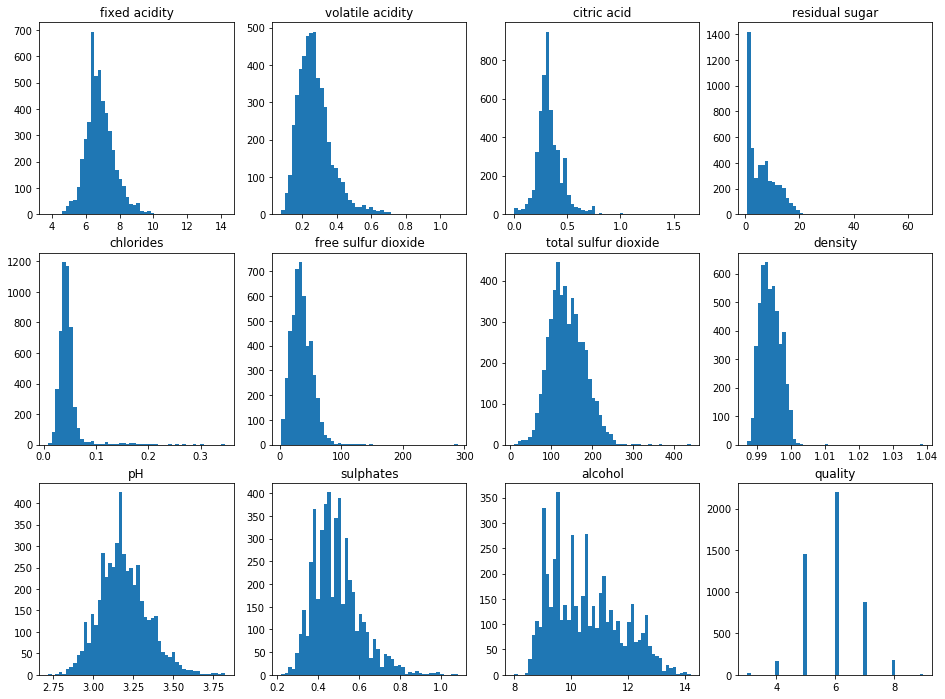

In [5]:
fig=plt.figure(figsize=(16,12))
for feat_idx, feat_name in enumerate(data.columns):
    ax=fig.add_subplot(3,4,feat_idx+1)
    ax.hist(data[feat_name],bins=50)
    ax.set_title(feat_name)

In [6]:
scaler=preprocessing.StandardScaler()
scaledX=pd.DataFrame(scaler.fit_transform(X))
scaledX.columns=X.columns

In [7]:
binarizedY=np.where(y>6,1,0)

In [8]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(scaledX, binarizedY,test_size=0.2, stratify=y)

## Reimplementation of the cross-validation function

In [9]:
def myGridSearchCV(estimator, param_grid, cv):
    param_names=list(param_grid.keys())
    param_names.append("mean_test_score")
    tmpRes=[]
    skf=model_selection.StratifiedKFold(cv)
    for param in model_selection.ParameterGrid(param_grid):
        estimator.set_params(**param)
        scores=[]
        for train_index,test_index in skf.split(Xtrain,ytrain):
            XtrainGS, XtestGS = Xtrain.iloc[train_index], Xtrain.iloc[test_index]
            ytrainGS, ytestGS = ytrain[train_index], ytrain[test_index]
            estimator.fit(XtrainGS, ytrainGS)
            scores.append(estimator.score(XtestGS,ytestGS))
        param.update({"mean_test_score":np.mean(scores)})
        tmpRes.append(param)
    cv_results_=pd.DataFrame(tmpRes, columns=param_names)
    return cv_results_

In [10]:
#example
myGridSearchCV(neighbors.KNeighborsClassifier(n_jobs=-1),{"n_neighbors":range(3,5),"p":[1,2], "leaf_size": [10,20,30]},cv=5)

,n_neighbors,p,leaf_size,mean_test_score
0,3,1,10,0.824664
1,3,2,10,0.818280
2,4,1,10,0.830787
3,4,2,10,0.829512
4,3,1,20,0.824664
5,3,2,20,0.818280
6,4,1,20,0.830787
7,4,2,20,0.829512
8,3,1,30,0.824664
9,3,2,30,0.818280


## cpu time comparison between reimplementation and official sklearn implementation

In [11]:
%%timeit
myGridSearchCV(neighbors.KNeighborsClassifier(n_jobs=-1),{"n_neighbors":range(3,5),"p":[1,2], "leaf_size": [10,20,30]},cv=5)

6.95 s ± 87.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
clf=model_selection.GridSearchCV(neighbors.KNeighborsClassifier(n_jobs=-1),{"n_neighbors":range(3,5),"p":[1,2], "leaf_size": [10,20,30]},cv=5,return_train_score=False)
clf.fit(Xtrain,ytrain)

2.17 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


L'implémentation officielle scikit-learn est plus rapide alors même qu'elle calcule un plus grand nombre d'indicateurs